# AI 감정 인식 모델 평가 (Evaluation)

이 노트북은 학습된 **ResNet 기반 감정 인식 모델(`emotion_resnet_best.pth`)**을 불러와서 성능을 상세하게 평가합니다.

**확인할 지표:**
- **Accuracy**: 전체 정확도
- **Precision / Recall / F1-Score**: 각 감정별(중립/불안) 인식 성능
- **Confusion Matrix**: 모델이 어떤 감정을 헷갈려하는지 시각화

In [1]:
!pip install seaborn

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import glob
import zipfile
import cv2
import mediapipe as mp
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# 외부 모듈 (process_single_image) 사용
from data_loader import process_single_image

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ============================
# [중요] 모델 구조 정의 
# (학습 때와 완전히 동일해야 가중치를 로드할 수 있음)
# ============================

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip Connection

class ResidualEmotionNet(nn.Module):
    def __init__(self, input_size, hidden_dim=512):
        super(ResidualEmotionNet, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        )
        
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        self.res_block3 = ResidualBlock(hidden_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        return self.classifier(x)

In [4]:
# ============================
# 평가 데이터 로드 함수
# ============================
BASE_DIR = r"c:\Users\ldy34\Desktop\Face\video"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")
NUM_WORKERS = os.cpu_count() or 4

def load_eval_data(max_samples=2000):
    # Validation 폴더가 있다면 거길 써도 좋지만, 
    # 여기서는 Training 폴더에서 일부를 가져와 테스트합니다.
    zip_files = glob.glob(os.path.join(TRAIN_DIR, "*.zip"))
    print(f"Found {len(zip_files)} zip files.")
    
    data_list = []
    for zip_path in zip_files:
        filename = os.path.basename(zip_path)
        if "중립" in filename or "Neutral" in filename:
            label = 0
        elif "불안" in filename or "Anxiety" in filename:
            label = 1
        else:
            continue
            
        with zipfile.ZipFile(zip_path, 'r') as z:
            file_list = [f for f in z.namelist() if f.lower().endswith(('.jpg', '.png'))]
            # 속도를 위해 일부만 사용
            use_count = min(len(file_list), max_samples)
            for img_name in file_list[:use_count]:
                with z.open(img_name) as f:
                    data_list.append((f.read(), label))
    
    print(f"Loading {len(data_list)} images for evaluation...")
    
    X, y = [], []
    # 병렬 처리로 랜드마크 추출
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(executor.map(process_single_image, data_list), total=len(data_list), desc="Extracting"))
        for res in results:
            if res is not None:
                X.append(res[0])
                y.append(res[1])
                
    return np.array(X), np.array(y)

In [5]:
# 1. 데이터 로드 및 전처리
X, y = load_eval_data(max_samples=3000) # 평가를 위해 조금 넉넉하게 3000개씩

# Train / Test Split (Test 셋만 사용)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"\nFinal Test Set Size: {len(X_test)} samples")

Found 35 zip files.
Loading 24000 images for evaluation...


Extracting: 100%|██████████| 24000/24000 [05:23<00:00, 74.12it/s] 



Final Test Set Size: 4800 samples


In [6]:
# 2. 모델 로드
MODEL_PATH = 'emotion_resnet_best.pth'

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("모델 파일이 없습니다! 먼저 학습을 완료해주세요.")

model = ResidualEmotionNet(input_size=X_test.shape[1]).to(device)

# DataParallel로 저장된 경우 처리
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # 평가 모드로 전환 (Dropout 비활성화)
print("Model loaded successfully!")

Model loaded successfully!


C:\Users\ldy34\AppData\Local\Temp\ipykernel_33308\3746582659.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


In [7]:
# 3. 예측 실행
y_true = []
y_pred = []

with torch.no_grad():
    for X_b, y_b in tqdm(test_loader, desc="Predicting"):
        X_b = X_b.to(device)
        outputs = model(X_b)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(y_b.numpy())
        y_pred.extend(predicted.cpu().numpy())

# 4. 결과 리포트 출력
print("\n" + "="*60)
print(classification_report(y_true, y_pred, target_names=['Neutral (중립)', 'Anxious (불안)']))
print("="*60)

Predicting:   0%|          | 0/38 [00:00<?, ?it/s]c:\Users\ldy34\Desktop\Face\.venv\Lib\site-packages\torch\nn\modules\linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Predicting: 100%|██████████| 38/38 [00:00<00:00, 72.86it/s]


              precision    recall  f1-score   support

Neutral (중립)       0.99      0.99      0.99      2400
Anxious (불안)       0.99      0.99      0.99      2400

    accuracy                           0.99      4800
   macro avg       0.99      0.99      0.99      4800
weighted avg       0.99      0.99      0.99      4800



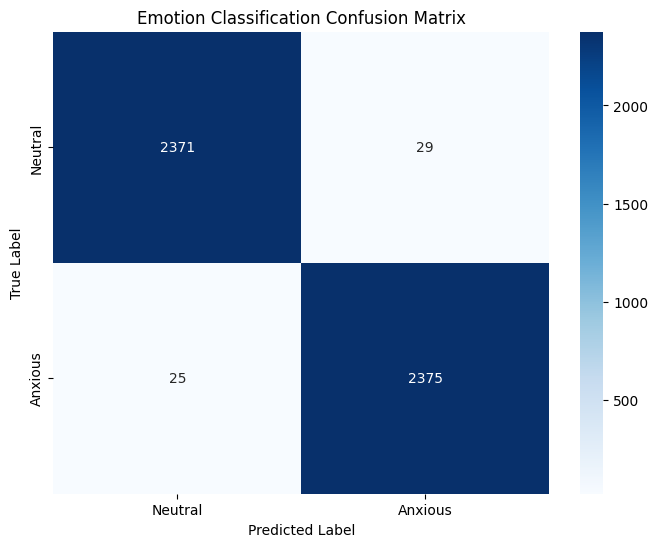

In [8]:
# 5. Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neutral', 'Anxious'], 
            yticklabels=['Neutral', 'Anxious'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Emotion Classification Confusion Matrix')
plt.show()